# OTSA alarm analyse (ppmg + regex)
*Wannes Meert*

In [1]:
import pandas as pd
from glob import glob
from datetime import datetime, timedelta
import time
import re
import subprocess as sp
from matplotlib import pyplot as plt
import pylab as pl
import numpy as np
import os
%matplotlib inline


/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3agg.py:18: UserWarning: The Gtk3Agg backend is known to not work on Python 3.x with pycairo. Try installing cairocffi.
  "The Gtk3Agg backend is known to not work on Python 3.x with pycairo. "


In [2]:
import sys
sys.path.append('regex/code')
learn_regex = 'regex/code/learnnoisyregex.py'
learn_ppmg = 'ppmg/learn_ppmg.py'

In [3]:
import platform
print('python:       {}'.format(platform.python_version()))
print('pandas:       {}'.format(pd.__version__))

python:       3.4.3
pandas:       0.18.0


In [4]:
%load_ext autoreload
%autoreload 2

In [20]:
def run(cmd):
    try:
        start = time.time()
        output = sp.check_output(cmd)
        print(output.decode('utf8'))
        print("Time: {:.2} s".format(time.time() - start))
    except sp.CalledProcessError as exc:
        print("Command failed: {}".format(" ".join(cmd)))
        print(exc.output.decode("utf8"))
        print(exc)

In [6]:
from IPython.display import Image, display_png
def showdot(filename):
    run(['dot', '-O', '-Tpng', filename])
    display_png(Image(filename=filename+".png"))

## Load data

In [7]:
#csv_files = glob('OTSA-alarmlogging/Control_Alarm_[0-9]*.csv')

In [8]:
#print('#csv-files: {}'.format(len(csv_files)))

In [9]:
def date_parser(x):
    return datetime.strptime(x[:-4], '%Y-%m-%d %H:%M:%S.%f')
#dfs = [pd.read_csv(csv_file, sep=';', index_col=0, parse_dates=[['Date', 'Time']], date_parser=date_parser) for csv_file in csv_files]
csv_file = "AzijnzuurAlarms.csv"
df = pd.read_csv(csv_file, sep=',', header=None, parse_dates=[1], date_parser=date_parser)
header = ["MessageDefinitionUID", "TimeCode", "Status", "MessageText", "AlarmId"]
df.columns = header
#df = pd.concat(dfs)
df = df.sort_values(by="TimeCode")
df[:10]

MessageDefinitionUID                TimeCode  Status  \
1965  A1CC4594-4CE7-4B69-8FD7-51A294F3136D 2015-11-16 22:15:17.801       1   
1966  A1CC4594-4CE7-4B69-8FD7-51A294F3136D 2015-11-16 22:15:34.510       2   
1967  D60C95BC-22DB-407F-A896-DBB796519FDC 2015-11-16 22:49:26.519       1   
1968  8D4D273E-81D8-4D39-B3A1-DDB7AE18CCFA 2015-11-16 22:49:26.519       1   
1969  D60C95BC-22DB-407F-A896-DBB796519FDC 2015-11-16 22:49:34.806       2   
1970  8D4D273E-81D8-4D39-B3A1-DDB7AE18CCFA 2015-11-16 22:49:34.806       2   
1971  FD8AF06B-3CEB-47C5-8235-D85B4027C83D 2015-11-16 23:02:50.814       1   
1972  3B2CBBDF-F8A4-4D13-898A-4381A0DE1F19 2015-11-16 23:35:13.529       1   
1973  A94CBAC4-A2E1-4EA1-9D25-01FB5B8E86DB 2015-11-17 04:28:38.712       1   
1974  3B2CBBDF-F8A4-4D13-898A-4381A0DE1F19 2015-11-17 04:28:58.660       2   

                                            MessageText AlarmId  
1965           FT_300_5_AL_VAR: VARIATIE ALARM IN ALARM     NaN  
1966           FT_300_5_AL_VAR: VARIATIE ALARM IN ALARM     NaN  
1967     FT_250_3_AL_INIT: INITIALISATIE ALARM IN ALARM     NaN  
1968           FT_250_3_AL_VAR: VARIATIE ALARM IN ALARM     NaN  
1969     FT_250_3_AL_INIT: INITIALISATIE ALARM IN ALARM     NaN  
1970           FT_250_3_AL_VAR: VARIATIE ALARM IN ALARM     NaN  
1971  TTWW_420_03_003: TEMPERATUURMETING WARMWATER U...     NaN  
1972  TTWW_420_03_003: TEMPERATUURMETING WARMWATER U...     NaN  
1973  PWW_420_03: CIRCULATIE POMP WARM WATER UNIT 42...     NaN  
1974  TTWW_420_03_003: TEMPERATUURMETING WARMWATER U...     NaN

In [10]:
df['MessageText2'] = df['MessageText'] + ' ' + df['Status'].astype(str)
df.head()

MessageDefinitionUID                TimeCode  Status  \
1965  A1CC4594-4CE7-4B69-8FD7-51A294F3136D 2015-11-16 22:15:17.801       1   
1966  A1CC4594-4CE7-4B69-8FD7-51A294F3136D 2015-11-16 22:15:34.510       2   
1967  D60C95BC-22DB-407F-A896-DBB796519FDC 2015-11-16 22:49:26.519       1   
1968  8D4D273E-81D8-4D39-B3A1-DDB7AE18CCFA 2015-11-16 22:49:26.519       1   
1969  D60C95BC-22DB-407F-A896-DBB796519FDC 2015-11-16 22:49:34.806       2   

                                         MessageText AlarmId  \
1965        FT_300_5_AL_VAR: VARIATIE ALARM IN ALARM     NaN   
1966        FT_300_5_AL_VAR: VARIATIE ALARM IN ALARM     NaN   
1967  FT_250_3_AL_INIT: INITIALISATIE ALARM IN ALARM     NaN   
1968        FT_250_3_AL_VAR: VARIATIE ALARM IN ALARM     NaN   
1969  FT_250_3_AL_INIT: INITIALISATIE ALARM IN ALARM     NaN   

                                          MessageText2  
1965        FT_300_5_AL_VAR: VARIATIE ALARM IN ALARM 1  
1966        FT_300_5_AL_VAR: VARIATIE ALARM IN ALARM 2  
1967  FT_250_3_AL_INIT: INITIALISATIE ALARM IN ALARM 1  
1968        FT_250_3_AL_VAR: VARIATIE ALARM IN ALARM 1  
1969  FT_250_3_AL_INIT: INITIALISATIE ALARM IN ALARM 2

## Split in bursts

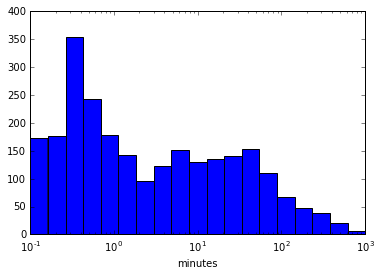

In [11]:
current = {'last_time': pd.Timestamp(0), 'diff': []}
def diffs(row, c):
    c['diff'].append(row.TimeCode - c['last_time'])
    c['last_time'] = row.TimeCode
df.apply(diffs, axis=1, args=(current,))

pl.hist([x.total_seconds()/60 for x in current["diff"]] , bins=10**np.linspace(-1, 3, 20))
pl.gca().set_xscale("log")
pl.xlabel("minutes")
pl.show()

In [23]:
max_delta_minutes = 30 # Maximal time between two events in the same burst
max_delta = pd.Timedelta(max_delta_minutes*60*10**9)
max_delta

Timedelta('0 days 00:30:00')

In [ ]:
current = {'last_time': pd.Timestamp(0), 'burst': 0}
def assign_burst(row, c):
    diff = row.TimeCode - c['last_time']
    c['last_time'] = row.TimeCode
    if diff > max_delta:
        c['burst'] += 1
    print(c)
    return c['burst']
df['burst'] = df.apply(assign_burst, axis=1, args=(current,))

In [25]:
print('#bursts: {}'.format(current['burst']))
# df[:10]

#bursts: 489


## Simplify Events

In [26]:
# Tank
# pattern = re.compile(""".*(TANK [0-9-]+).*""")
# Tank + Leidings + Pomp
pattern = re.compile(""".*(TANK [0-9-]+|ANT_[T0-9]+|LEIDING [0-9]+|POMP P[0-9]+).*""")

In [27]:
with open('events_tanks.txt', 'w') as ofile:
    prev_burst = 0
    prev = None
    for idx,row in df.iterrows():
        msg = row['MessageText2']
        result = pattern.match(msg)
        if result is not None and result.group(1) != prev:
            if prev_burst != row['burst']:
                print('', file=ofile)
                prev_burst = row['burst']
            print("{:<16}  # {} {}".format(result.group(1).replace(' ', '_'), idx, row['burst']), file=ofile)
            prev = result.group(1)

## Without simplification

In [28]:
def insert_newlines(string, every=15):
    return '<br/>'.join(string[i:i+every] for i in range(0, len(string), every))

with open('events_tanks.txt', 'w') as ofile:
    prev_burst = 0
    prev = None
    for idx,row in df.iterrows():
        msg = row['MessageText']    
        if prev_burst != row['burst']:
            print('', file=ofile)
            prev_burst = row['burst']
        print("{:<s}  # {} {}".format(insert_newlines(msg.replace(' ', '_')), idx, row['burst']), file=ofile)


### Regex

In [29]:
run([learn_regex, '-v', '-k 10', '--prune', '2', '--onlytranscounts', '--drawoutliers', '0.1', 'events_tanks.txt'])

[INFO] Learning DFA ...
[INFO] Reading data files: events_tanks.txt
[INFO] DFA equations:
0 := ( "PWW_420_03:_CIR<br/>CULATIE_POMP_WA<br/>RM_WATER_UNIT_4<br/>20_03_001_IN_HA<br/>ND" 65|( "PDIT_420_03_003<br/>:_VERSCHILDRUKM<br/>ETING_OVER_FLAM<br/>E_ARRESTOR_T420<br/>_03_HOOG_ALARM" 1047| "" __TERM__))
1 :=  "PWW_420_02:_CIR<br/>CULATIE_POMP_WA<br/>RM_WATER_UNIT_4<br/>20_02_001_IN_HA<br/>ND" 385
2 :=  "PTWW_300_6_7_00<br/>1:_DRUK_WARMWAT<br/>ERUNT_T300_6_LA<br/>AG_ALARM" 633
3 :=  "TTWW_420_03_003<br/>:_TEMPERATUURME<br/>TING_WARMWATER_<br/>UNIT_WW_T420_03<br/>_HOOG_HOOG_ALAR<br/>M" 43
4 :=  "XV_250_4_010:_A<br/>FSLUITER_STEIGE<br/>R_623_IN_SIMULA<br/>TIE" 1692
5 := ( "TTWW_420_02_003<br/>:_TEMPERATUURME<br/>TING_WARMWATER_<br/>UNIT_WW_T420_02<br/>_HOOG_ALARM" 1614| "PWW_420_02:_CIR<br/>CULATIE_POMP_WA<br/>RM_WATER_UNIT_4<br/>20_02_001_IN_HA<br/>ND" 373)
6 :=  "PDIT_420_03_003<br/>:_VERSCHILDRUKM<br/>ETING_OVER_FLAM<br/>E_ARRESTOR_T420<br/>_03_HOOG_HOOG_A<br/>LARM" 172
7 :=  "XS_TR40_T

In [30]:
print("file size:", os.path.getsize("states_counts.dot"), "bytes")

file size: 51007 bytes


In [31]:
showdot('states_counts.dot')


Time: 4.5 s


### PPMG

In [ ]:
run([learn_ppmg, '-v', '--minamount', '2', 'events_tanks.txt'])


In [ ]:
showdot('ppmg.dot')